In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from jepa.utils import set_seed
from jepa.dataset import load_cifar, load_mnist
from jepa.model.autoencoder import AutoEncoder, AutoencoderCriterion
from jepa.model.jepa import Jepa
import json

In [21]:
device = "cpu" if not torch.cuda.is_available() else "cuda"
print("Using device: ", device)

seed = 30
wandb_project = "jepa-prove"

batch_size = 64
test_size = 2048

Using device:  cpu


## Autoencoder

In [23]:
chkpt_dir = "../checkpoints/AutoEncoder/cifar10-train"
model, chkpt_metadata = AutoEncoder.from_pretrained(chkpt_dir, device)
print(json.dumps(chkpt_metadata, indent=2))

{
  "step": 12800,
  "epoch": 50,
  "date": "2024-04-18 16:32:32",
  "optimizer": {
    "lr": 0.0005,
    "betas": [
      0.9,
      0.999
    ],
    "eps": 1e-08,
    "weight_decay": 0.1,
    "amsgrad": false,
    "foreach": null,
    "maximize": false,
    "capturable": false,
    "differentiable": false,
    "fused": null,
    "type": "AdamW"
  },
  "architecture": {
    "type": "AutoEncoder",
    "input_dim": 3072,
    "hidden_layers": [
      30
    ],
    "activation": "ReLU",
    "decoder_hidden": []
  },
  "hyperparameters": {
    "lr": 0.0005,
    "rho": null,
    "batch_size": 64,
    "max_epochs": 50,
    "weight_decay": 0.1,
    "optimizer": "AdamW",
    "criterion": {
      "criterion": "AutoencoderCriterion",
      "reconstruction_error": "MSELoss",
      "sparsity_weight": 0.0
    },
    "scheduler": null,
    "train_size": 16384,
    "test_size": 2048,
    "target_loss": 0.0,
    "seed": 30,
    "compile_model": true,
    "train_set_percentage_for_flatness": 0.125
  },

In [24]:
id = chkpt_metadata["train_set"]["id"]
if "mnist" in id:
    load_dataset = load_mnist
elif "cifar10" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=10, **kwargs)
elif "cifar100" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=100, **kwargs)
else:
    raise ValueError("Unknown dataset")

train_size = chkpt_metadata["train_set"]["num_samples"]
test_size = chkpt_metadata["test_set"]["num_samples"]
shuffle = chkpt_metadata["train_set"]["shuffle"]  # assume same shuffle for test set (!)

In [25]:
# dataset
root = "../data"
train_dataset, train_metadata = load_dataset(train=True, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=train_size)
test_dataset, test_metadata = load_dataset(train=False, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=test_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_size)  # be mindful of the batch size

Files already downloaded and verified
Files already downloaded and verified


In [26]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=3072, bias=True)
  )
)

### Classification

In [27]:
from jepa.evaluation import train_classifier, build_dataset_of_latents
from matplotlib import pyplot as plt


train_latents_dataset = build_dataset_of_latents(model.encoder, train_loader, device)
train_latents_dl = DataLoader(train_latents_dataset, batch_size=batch_size, shuffle=True)
test_latents_dataset = build_dataset_of_latents(model.encoder, test_loader, device)
test_latents_dl = DataLoader(test_latents_dataset, batch_size=test_size, shuffle=False)
num_classes = len(train_latents_dataset.labels.unique())

Final accuracy:  0.39111328125 Max accuracy:  0.39794921875


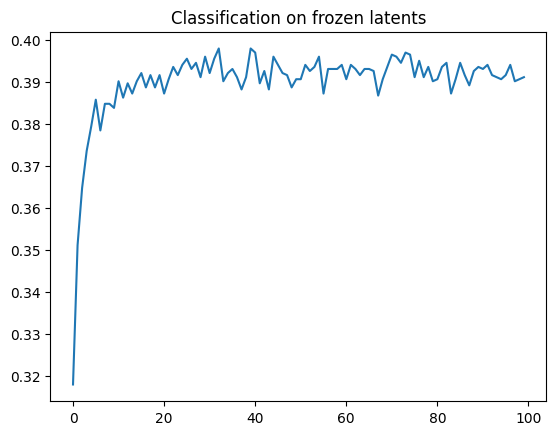

In [28]:
latent_dim = next(iter(train_latents_dl))['x'].shape[1]
classifier = nn.Linear(latent_dim, num_classes)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

accs = train_classifier(classifier, train_latents_dl, test_latents_dl, criterion=criterion,
                        optimizer=optimizer, epochs=100, device=device)

plt.plot(accs)
plt.title("Classification on frozen latents")
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()

Final accuracy:  0.37060546875 Max accuracy:  0.39404296875


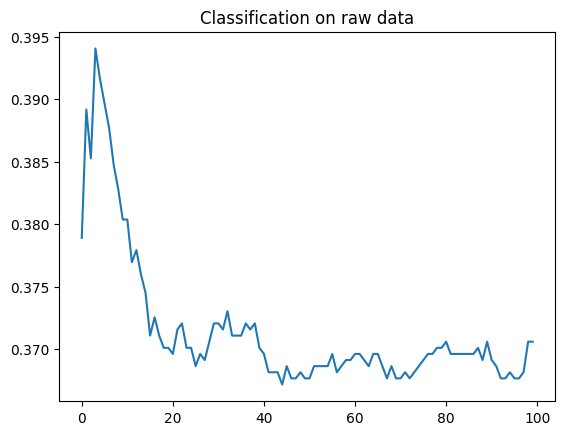

In [29]:
input_dim = next(iter(train_loader))['x'].shape[1]
classifier = nn.Linear(input_dim, num_classes).to(device)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

accs = train_classifier(classifier, train_loader, test_loader, criterion=criterion,
                                   optimizer=optimizer, epochs=100, device=device)

plt.plot(accs)
plt.title("Classification on raw data")
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()

## Jepa

In [30]:
chkpt_dir = "../checkpoints/Jepa/cifar10-train"
model, chkpt_metadata = Jepa.from_pretrained(chkpt_dir, device)
print(json.dumps(chkpt_metadata, indent=2))

{
  "step": 5120,
  "epoch": 20,
  "date": "2024-04-18 16:31:28",
  "optimizer": {
    "lr": 0.001,
    "betas": [
      0.9,
      0.999
    ],
    "eps": 1e-08,
    "weight_decay": 0.1,
    "amsgrad": false,
    "foreach": null,
    "maximize": false,
    "capturable": false,
    "differentiable": false,
    "fused": null,
    "type": "AdamW"
  },
  "architecture": {
    "type": "Jepa",
    "encoder": "Sequential(\n  (0): Linear(in_features=3072, out_features=30, bias=True)\n)",
    "predictor": "Sequential(\n  (0): Linear(in_features=30, out_features=30, bias=True)\n)"
  },
  "hyperparameters": {
    "lr": 0.001,
    "rho": null,
    "batch_size": 64,
    "max_epochs": 20,
    "weight_decay": 0.1,
    "optimizer": "AdamW",
    "criterion": {
      "criterion": "JepaCriterion",
      "reconstruction_error": "MSELoss",
      "sparsity_weight": 0.0
    },
    "scheduler": null,
    "train_size": 16384,
    "test_size": 2048,
    "target_loss": 0.0,
    "seed": 30,
    "compile_model": 

In [31]:
id = chkpt_metadata["train_set"]["id"]
if "mnist" in id:
    load_dataset = load_mnist
elif "cifar10" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=10, **kwargs)
elif "cifar100" in id:
    def load_dataset(**kwargs):
        return load_cifar(num_classes=100, **kwargs)
else:
    raise ValueError("Unknown dataset")

train_size = chkpt_metadata["train_set"]["num_samples"]
test_size = chkpt_metadata["test_set"]["num_samples"]
shuffle = chkpt_metadata["train_set"]["shuffle"]  # assume same shuffle for test set (!)

In [32]:
# dataset
root = "../data"
train_dataset, train_metadata = load_dataset(train=True, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=train_size)
test_dataset, test_metadata = load_dataset(train=False, log_to_wandb=False, 
    project=wandb_project, root=root, jepa=False, shuffle=seed, num_samples=test_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_size)  # be mindful of the batch size

Files already downloaded and verified
Files already downloaded and verified


In [33]:
model

Jepa(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=30, bias=True)
  )
  (predictor): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
  )
  (ema): Sequential(
    (0): Linear(in_features=3072, out_features=30, bias=True)
  )
)

In [34]:
from jepa.evaluation import train_classifier, build_dataset_of_latents
from matplotlib import pyplot as plt


train_latents_dataset = build_dataset_of_latents(model.ema, train_loader, device)
train_latents_dl = DataLoader(train_latents_dataset, batch_size=batch_size, shuffle=True)
test_latents_dataset = build_dataset_of_latents(model.ema, test_loader, device)
test_latents_dl = DataLoader(test_latents_dataset, batch_size=test_size, shuffle=False)
num_classes = len(train_latents_dataset.labels.unique())

Final accuracy:  0.34130859375 Max accuracy:  0.3525390625


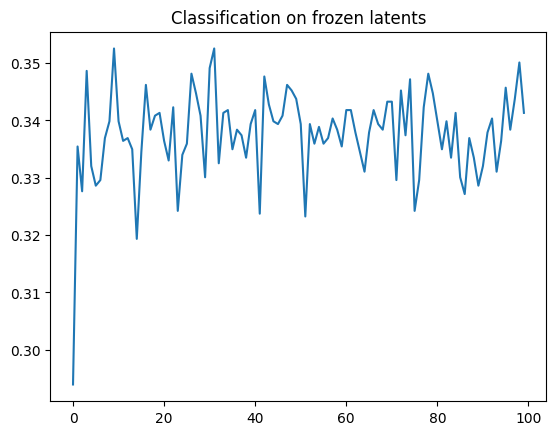

In [35]:
latent_dim = next(iter(train_latents_dl))['x'].shape[1]
classifier = nn.Linear(latent_dim, num_classes)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

accs = train_classifier(classifier, train_latents_dl, test_latents_dl, criterion=criterion,
                        optimizer=optimizer, epochs=100, device=device)

plt.plot(accs)
plt.title("Classification on frozen latents")
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()

Final accuracy:  0.37060546875 Max accuracy:  0.39404296875


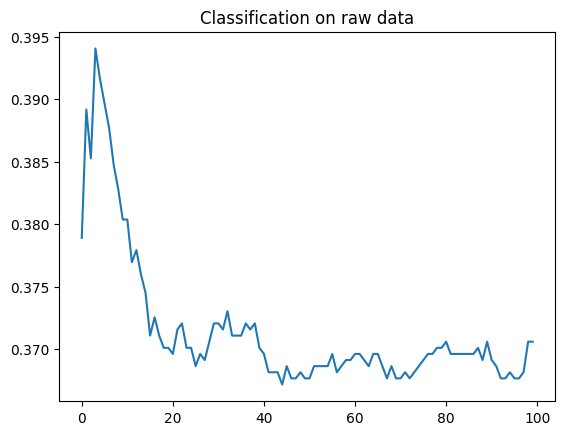

In [41]:
input_dim = next(iter(train_loader))['x'].shape[1]
classifier = nn.Linear(input_dim, num_classes).to(device)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)

accs = train_classifier(classifier, train_loader=train_loader, test_loader=test_loader,
                        criterion=criterion, optimizer=optimizer, epochs=100, device=device)

plt.plot(accs)
plt.title("Classification on raw data")
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()

## Random Projection

In [37]:
import torch
from torch import nn

encoder = nn.Linear(3072, 30)
# load_dataset = load_mnist
# train_size = 16384

In [38]:
root = "../data"

train_dataset, train_metadata = load_dataset(train=True, log_to_wandb=False,
                    root=root, jepa=False, shuffle=seed, num_samples=train_size)
test_dataset, test_metadata = load_dataset(train=False, log_to_wandb=False, 
                    root=root, jepa=False, shuffle=seed, num_samples=test_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_size)  # be mindful of the batch size

Files already downloaded and verified
Files already downloaded and verified


In [39]:
from jepa.evaluation import train_classifier, build_dataset_of_latents
from matplotlib import pyplot as plt


train_latents_dataset = build_dataset_of_latents(encoder, train_loader, device)
train_latents_dl = DataLoader(train_latents_dataset, batch_size=batch_size, shuffle=True)
test_latents_dataset = build_dataset_of_latents(encoder, test_loader, device)
test_latents_dl = DataLoader(test_latents_dataset, batch_size=test_size, shuffle=False)
num_classes = len(train_latents_dataset.labels.unique())

Final accuracy:  0.3125 Max accuracy:  0.3193359375


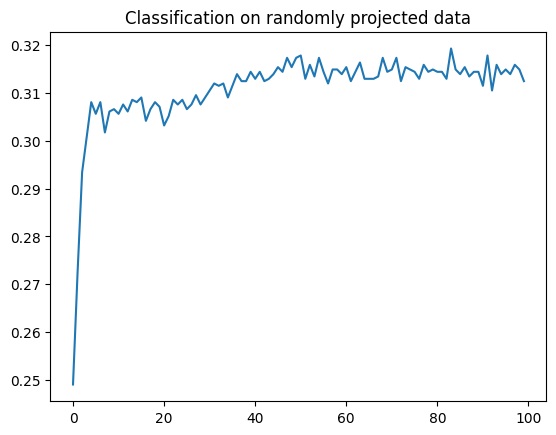

In [40]:
latent_dim = next(iter(train_latents_dl))['x'].shape[1]
classifier = nn.Linear(latent_dim, num_classes)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

accs = train_classifier(classifier, train_latents_dl, test_latents_dl, criterion=criterion,
                        optimizer=optimizer, epochs=100, device=device)

plt.plot(accs)
plt.title("Classification on randomly projected data")
print("Final accuracy: ", accs[-1], "Max accuracy: ", max(accs))
plt.show()